In [1]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import json
import urllib.request
from sklearn.metrics import r2_score
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# from sklearn.model_selection import TimeSeriesSplit

In [2]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [3]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [4]:
new_links = ["https://socialblade.com/youtube/user/mmoshaya/monthly",
            "https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
            "https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
            "https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
            "https://socialblade.com/youtube/user/banderitax/monthly",
            "https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [5]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [6]:
# save new req to html file if not found
for i in range(len(new_links)):
    if f"new_req{i}.html" not in os.listdir('.'):
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        response = str(opener.open(new_links[i]).read())
        open("new_req"+str(i)+".html","w").write(response)

In [7]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]
# read files from  disk - files name: new_req0.html .... new_req4.html
new_resText = [open("new_req"+str(i)+".html","r").read() for i in range(len(new_links))]

In [8]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [9]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [10]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [11]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [12]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [13]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [14]:
def getAllCharts_newlinks(response):
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,-?\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in allCharts[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in allCharts[0]],
        col[1]: [i[1] for i in allCharts[1]],
    })

    date2 = pd.Series([i[0] for i in allCharts[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[2]],
        "TotalVideoViews": [i[1] for i in allCharts[3]],
    })

    date3 = pd.Series([i[0] for i in allCharts[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[4]],
        "TotalVideoViews": [i[1] for i in allCharts[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [15]:
def concatOldDataWithNew(old_df,new_df):
    concated = pd.concat([old_df[["Date","TotalSubscribers","TotalVideoViews"]],new_df[1],new_df[2]])
    return concated.sort_values(by="Date",ignore_index=True) # sort by date and reset index

In [16]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [17]:
channels_df = [getAllCharts(soup) for soup in soups]

In [18]:
#     X_y = channels_df[0][["Date","TotalSubscribers"]]
#     X_y.columns = ["ds","y"]
#     md = Prophet()
#     md.fit(X_y)
#     future = md.make_future_dataframe(365)
#     forecast = md.predict(future)
#     ys_yhats=X_y.merge(forecast[["ds","yhat"]],on="ds")
#         ############ Validation #############
#     df_cv = cross_validation(md,horizon = '150 days')

In [19]:
# plt.scatter(df_cv.y,df_cv.yhat)
# sns.boxplot(X_y.y[X_y.y<1.7e7])
# r2_score(df_cv.y,df_cv.yhat)
# fig = plot_cross_validation_metric(df_cv, metric='mape')
# r2_score(ys_yhats.y,ys_yhats.yhat)

In [20]:
#  md.plot_components(forecast)

In [21]:
new_channels_df = [getAllCharts_newlinks(r) for r in new_resText]

In [22]:
top1_df = concatOldDataWithNew(channels_df[0], new_channels_df[0]) # top 1 channel df
top2_df = concatOldDataWithNew(channels_df[1], new_channels_df[1]) # top 2 channel df
# top3_df = concatOldDataWithNew(channels_df[2], new_channels_df[2]) # top 3 channel df
top3_df = concatOldDataWithNew(channels_df[3], new_channels_df[3]) # top 4 channel df شلناها لان عدد الروز قليل
top4_df = concatOldDataWithNew(channels_df[4], new_channels_df[4]) # top 4 channel df
top5_df = concatOldDataWithNew(channels_df[5], new_channels_df[5]) # top 4 channel df

In [23]:
top_channels = {
    "mmoshaya":top1_df,
    "ARAB GAMES NETWORK":top2_df,
    "Anasala":top3_df,
    "BanderitaX":top4_df,
    "Rawan and Rayan":top5_df
}

In [24]:
subs_forecasts = {}
for cn,df in top_channels.items():
    X_y = df[["Date","TotalSubscribers"]]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(730)
    # forecast = md.predict(future)
    subs_forecasts[cn] = md.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
views_forecasts = {}
for cn,df in top_channels.items():
    X_y = df[["Date","TotalVideoViews"]]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(730)
    # forecast = md.predict(future)
    views_forecasts[cn] = md.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
# df = channels_df[0][["Date","TotalSubscribers"]]
# fig = px.line(data_frame=X_y.drop_duplicates(subset="y"),x="ds",y="y",markers=True)
subsfigs = {}
for cn,forecast in subs_forecasts.items():
    col_map = {"yhat":"Total Subscribers","yhat_lower":"Minimum","yhat_upper":"Maximum"}

    fig = px.line(data_frame=forecast.rename(columns=col_map),x="ds",y=['Total Subscribers', 'Minimum', 'Maximum'])
    # fig = go.Figure()
    # fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat_lower, fill='none')) # fill down to xaxis
    # fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, fill='tonexty')) # fill to trace0 y
    # fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat_upper, fill='tonexty')) # fill to trace1 y
    # fig.update_layout({"xaxis":{"rangeslider_visible":True}})
    fig.update_layout(
        title= cn+" Total Subscribers Time Series for the Next Five Years",
        xaxis_title="Date",
        yaxis_title="Total Subsctibtions",
        legend_title="",
    )
    fig.update_xaxes(title_text="Date",rangeslider_visible=True,calendar="islamic")
    subsfigs[cn] = fig
# fig.update_yaxes(title_text="Total Subscriptions")
# fig.write_html("fig1.html",config={'displaylogo': False})
# fig.show(config={'displaylogo': False}) # hide plotly logo =)
# fig.add_trace(go.Scatter(x=pd.concat([forecast.ds,forecast.ds[::-1]]),y=pd.concat([forecast.yhat_upper,forecast.yearly_lower[::-1]]),fill="toself"))
# go.Scatter()
# df = channels_df[0][["Date","TotalVideoViews"]]
# fig = px.scatter(data_frame=df[df["TotalVideoViews"] != 0],x="Date",y="TotalVideoViews")
# fig.show()

In [27]:
viewsfigs = {}
for cn,forecast in views_forecasts.items():
    col_map = {"yhat":"Total Subscribers","yhat_lower":"Minimum","yhat_upper":"Maximum"}

    fig = px.line(data_frame=forecast.rename(columns=col_map),x="ds",y=['Total Subscribers', 'Minimum', 'Maximum'])
    fig.update_layout(
        title=cn+" Total Subscribers Time Series for the Next Five Years",
        xaxis_title="Date",
        yaxis_title="Total Subsctibtions",
        legend_title="",
    )
    fig.update_xaxes(title_text="Date",rangeslider_visible=True,calendar="islamic")
    viewsfigs[cn] = fig

In [28]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [29]:
app = dash.Dash()#__name__)

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options
col_map = {"yhat":"Total Subscribtion","yhat_lower":"Minimum","yhat_upper":"Maximum"}

fig = px.line(data_frame=forecast.rename(columns=col_map),x="ds",y=['Total Subscribtion', 'Minimum', 'Maximum'])
fig.update_layout(
    title="mmoshaya Total Subscribers Time Series for the Next Two Years",
    xaxis_title="Date",
    yaxis_title="Total Subscribers",
    legend_title="",
)
fig.update_xaxes(rangeslider_visible=True,calendar="islamic")
# fig.show(config={'displaylogo': False}) # hide plotly logo =)

app.layout = html.Div([
    html.H1(children='Top Five Youtube Channels Subscribers Forecasting'),
    html.Div(['''
        Channel name:
        ''',
        dcc.Dropdown(
                    id='channel-name',
                    options=[{'label': i, 'value': i} for i in subsfigs.keys()],
                    value="mmoshaya",
#                     style={'width':'48%','display': 'inline-block'}
                    ),
              '''
              Calendar type:
              ''',
        dcc.RadioItems(id='calendar-type',
                    options=[{'label': i, 'value': i} for i in ['islamic', 'gregorian']],
                    value='islamic'),],
             style={"margin":"0px 20px"}
            ),

    dcc.Graph(
        id='TS-graph',
        figure=fig
    )
])
# dcc.Graph()
@app.callback(
    Output('TS-graph','figure'),
    Input('channel-name','value'),
    Input('calendar-type','value')
)
def changeCalType(cn,ct):
    fig = subsfigs[cn]
#         fig.update_layout(title=cn+" Total Subsctibtions Time Series for the Next Five Years")
    fig.update_xaxes(calendar=ct)
    return fig

# @app.callback(
#     Output('TS-graph','figure'),
#     Input('calendar-type','value')
# )
# def changeCalType(ct):
#     fig.update_xaxes(calendar=ct)
#     return fig
# if __name__ == '__main__':
app.run_server()

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [26/Sep/2021 18:23:04] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Sep/2021 18:23:05] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Sep/2021 18:23:05] "GET /_dash-layout HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\Raed\anaconda3\lib\site-packages\dash\dash.py", line 1078, in dispatch
    response.set_data(fun

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Raed\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\Raed\anaconda3\lib\site-packages\dash\dash.py", line 1078, in dispatch
    respon

In [112]:

fig = go.Figure(layout = dict(title="Total Subscribers Time Series for Top Five Youtube Channels",
                        xaxis_title="Date",
                        yaxis_title="Total Subscribers"))#make_subplots(5,1)
for cn,df in top_channels.items():
    fig.add_trace(go.Scatter(x=df["Date"],y=df["TotalSubscribers"],name=cn))
# fig.update_layout(height=1200)
fig.show()


In [108]:
for ch in subs_forecasts:
    print(round(((ch["yhat"].iloc[-1]/ch["yhat"].iloc[-730])-1)*100,2),"%")

43.43 %
55.71 %
79.63 %
55.59 %
45.59 %


In [24]:
# top1_df = channels_df[0] # top 1 channel df
# top2_df = channels_df[1] # top 2 channel df
# top3_df = channels_df[2] # top 3 channel df
# # top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
# top4_df = channels_df[4] # top 4 channel df
# top5_df = channels_df[5] # top 4 channel df

In [25]:
# X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
# X_y.columns = ["ds","y"]
# m = Prophet(daily_seasonality=True)
# m.fit(X_y)

In [26]:
# future = m.make_future_dataframe(periods=365)

In [27]:
# forecast = m.predict(future)

In [28]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [29]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [30]:
#  m.plot_components(forecast)

In [31]:
# sns.pairplot(top1_df)

In [32]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [33]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [34]:
# nonZero = channels_df[0][channels_df[0].DailyVideoViews != 0]

In [35]:
# nonZero.join(nonZero.Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [36]:
# channels_df[0].join(channels_df[0].Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [37]:
# iso = channels_df[0].join(channels_df[0].Date.dt.isocalendar())
# # iso.where(iso.day == 1).first_valid_index()
# s = iso[iso.day ==1].iloc[0].name
# e = iso[iso.day ==7].iloc[-1].name


In [38]:
# iso.iloc[s:e+1].groupby(["year","week"]).day.count().value_counts()

In [39]:
# (new_channels_df[0][0].Date.dt.isocalendar().day == 1).value_counts()

In [40]:
ys_yhats = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(0)
    forecast = md.predict(future)
    ys_yhats.append(X_y.merge(forecast[["ds","yhat"]],on="ds"))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
df_cv = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
        ############ Validation #############
    df_cv.append(cross_validation(md,horizon = '170 days'))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-16 04:00:00 and 2021-03-20 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-31 04:00:00 and 2021-04-04 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 14 forecasts with cutoffs between 2018-03-19 04:00:00 and 2021-03-28 04:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-24 04:00:00 and 2021-03-28 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2018-06-19 04:00:00 and 2021-04-04 04:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

## Validation Plots

0.9859983658404097
0.9922268014750664
0.9773864961547822
0.9807096105368093
0.9839014307188388


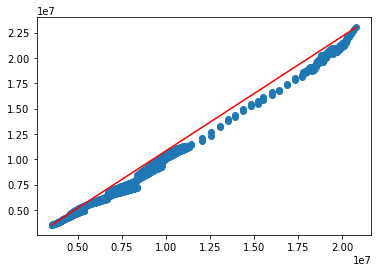

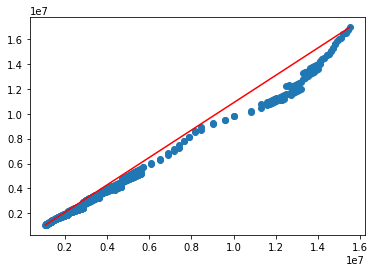

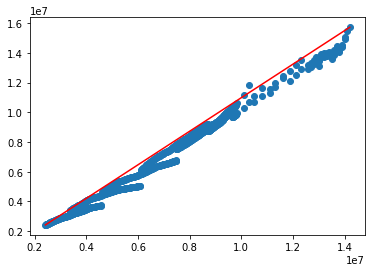

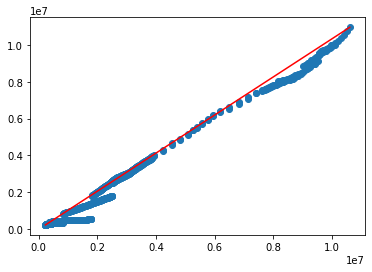

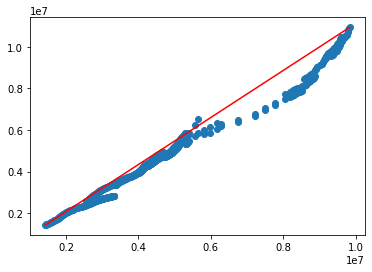

<Figure size 432x288 with 0 Axes>

In [42]:
for df in df_cv:
    plt.scatter(df.y,df.yhat)
    x_plt_range = [df.y.min(),df.y.max()]
    y_plt_range = [df.yhat.min(),df.yhat.max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()
    print(r2_score(df.y,df.yhat))
#     plot_cross_validation_metric(df, metric='mae')

## Training Plots

0.9988892876560596
0.999303402122512
0.9997237512039455
0.9998401720840386
0.9990697991832899


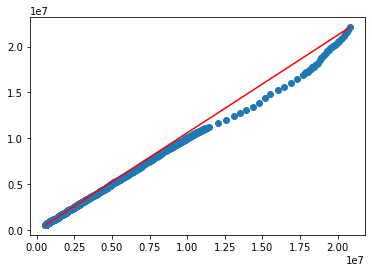

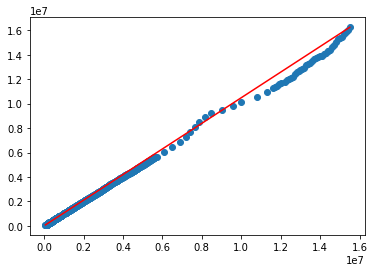

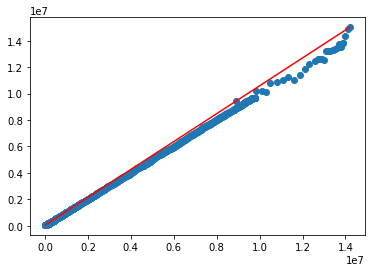

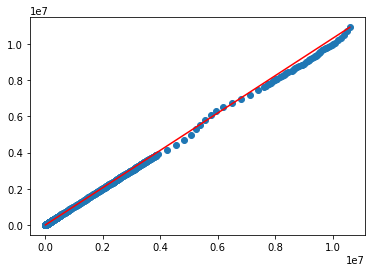

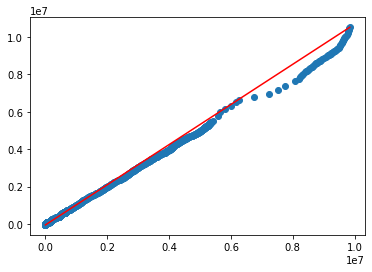

<Figure size 432x288 with 0 Axes>

In [43]:
for y_yhat in ys_yhats:
    print(r2_score(y_yhat["y"],y_yhat["yhat"]))
    plt.scatter(y_yhat["y"],y_yhat["yhat"])
    x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
    y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()

In [44]:
# tss = TimeSeriesSplit()
# for tarin,val in tss.split(X_y):
md = Prophet()
md.fit(X_y)

In [45]:
# for train,val in kf:
#     print("train Range:",min(train),max(train),"val Range:",min(val),max(val))
X_y.ds

0      2016-11-06 00:00:00
1      2016-11-07 00:00:00
2      2016-11-08 00:00:00
3      2016-11-09 00:00:00
4      2016-11-10 00:00:00
               ...        
1067   2021-08-21 04:00:00
1068   2021-08-29 04:00:00
1069   2021-09-06 04:00:00
1070   2021-09-14 04:00:00
1071   2021-09-21 04:00:00
Name: ds, Length: 1072, dtype: datetime64[ns]

In [47]:
# df_cv = cross_validation(md,initial='730 days', period='100 days', horizon = '200 days')

In [ ]:
df_cv

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(df_cv.y,df_cv.yhat)
plt.plot([0.7e7,2.2e7],[0.7e7,2.2e7],c="r")

In [ ]:
r2_score(df_cv.y,df_cv.yhat)

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [ ]:
future = md.make_future_dataframe(periods=365)

In [ ]:
future

In [ ]:
forecast = md.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
 md.plot_components(forecast)

In [ ]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

In [ ]:
r2_score()

In [ ]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)